In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy as np
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from util.preprocessing import extract_window, plot_and_save_ecg_window

In [2]:
# Read csv from ptb-xl/ptbxl_database.csv
df = pd.read_csv("ptb-xl/ptbxl_database.csv")

# Replace all single quotes with double quotes
df["scp_codes"] = df["scp_codes"].apply(lambda x: x.replace("'", '"'))

# JSON decode all df["scp_codes"]
df["scp_codes"] = df["scp_codes"].apply(json.loads)

# Print the first 5 rows of the dataframe
print(df.head())
print(df.count())

   ecg_id  patient_id   age  sex  height  weight  nurse  site     device  \
0       1     15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
1       2     13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
2       3     20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
3       4     17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
4       5     17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

        recording_date  ... validated_by_human  baseline_drift static_noise  \
0  1984-11-09 09:17:34  ...               True             NaN    , I-V1,     
1  1984-11-14 12:55:37  ...               True             NaN          NaN   
2  1984-11-15 12:49:10  ...               True             NaN          NaN   
3  1984-11-15 13:44:57  ...               True    , II,III,AVF          NaN   
4  1984-11-17 10:43:15  ...               True   , III,AVR,AVF          NaN   

  burst_noise electrodes_problems  extra_beats  pacemaker  strat_fol

In [3]:
# NORM => Normal
# 1AVB => First-Degree Atrioventricular Block (1dAVb)
# IRBBB, CRBBB => RBBB => Right Bundle Branch Block (RBBB)
# ILBBB, CLBBB => LBBB => Left Bundle Branch Block (LBBB)
# AFLT => Atrial Flutter (AFLT)
# AFIB => Atrial Fibrillation (AFIB)
labels = ["NORM", "1AVB", "RBBB", "LBBB", "AFLT", "AFIB"]

# Add a new column called "diagnosis" and use the key with the highest value
df["diagnosis"] = df["scp_codes"].apply(lambda x: max(x, key=x.get))

# Combine IRBBB and CRBBB into RBBB
df["diagnosis"] = df["diagnosis"].replace("IRBBB", "RBBB")
df["diagnosis"] = df["diagnosis"].replace("CRBBB", "RBBB")

# Combine ILBBB and CLBBB into LBBB
df["diagnosis"] = df["diagnosis"].replace("ILBBB", "LBBB")
df["diagnosis"] = df["diagnosis"].replace("CLBBB", "LBBB")

# Convert df["diagnosis"] to OTHERS where df["diagnosis"] is not within labels
df["diagnosis"] = df["diagnosis"].apply(lambda x: x if x in labels else "OTHERS")

# Drop every column except "diagnosis", "filename_lr", "filename_hr"
df = df[["diagnosis", "filename_lr", "filename_hr"]]

# Reset the index so that the index is the row number
df = df.reset_index(drop=True)

# Print the first 5 rows of the dataframe
print(df.head())
print(df.count())

# Print the distribution of the diagnoses by their diagnosis
print(df["diagnosis"].value_counts())

  diagnosis                filename_lr                filename_hr
0      NORM  records100/00000/00001_lr  records500/00000/00001_hr
1      NORM  records100/00000/00002_lr  records500/00000/00002_hr
2      NORM  records100/00000/00003_lr  records500/00000/00003_hr
3      NORM  records100/00000/00004_lr  records500/00000/00004_hr
4      NORM  records100/00000/00005_lr  records500/00000/00005_hr
diagnosis      21799
filename_lr    21799
filename_hr    21799
dtype: int64
diagnosis
OTHERS    10576
NORM       9134
RBBB       1216
LBBB        572
1AVB        201
AFLT         55
AFIB         45
Name: count, dtype: int64


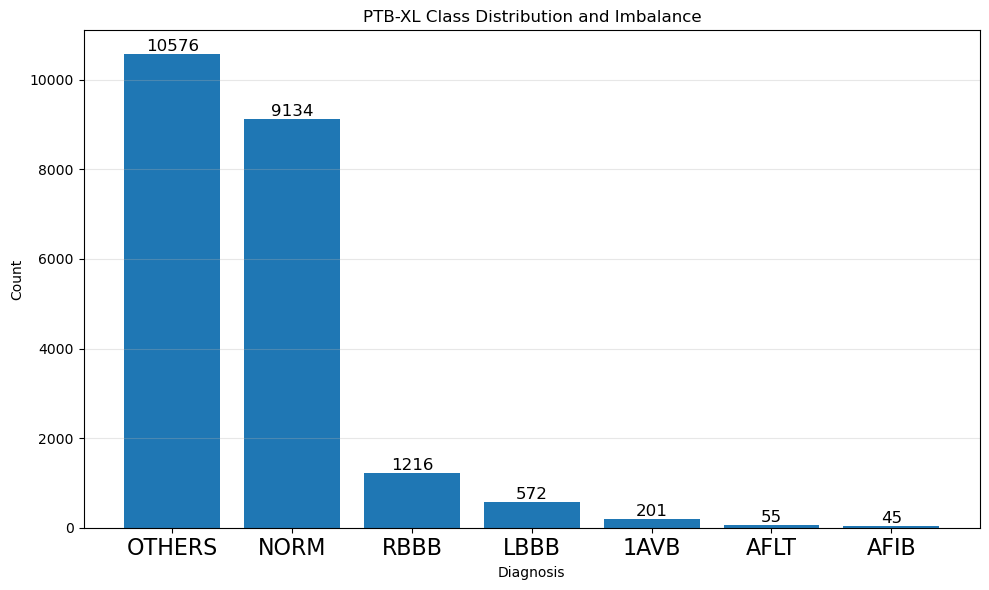

In [4]:
# Get value counts and sort in descending order
counts = df["diagnosis"].value_counts().sort_values(ascending=False)

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values)
plt.title("PTB-XL Class Distribution and Imbalance")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of each bar
for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

plt.xticks(range(len(counts.index)), counts.index, fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
records = df[["diagnosis", "filename_lr"]].to_dict(orient="records")

X_windows = []
y_labels = []

for rec in tqdm(records, desc="Extracting records"):
    win = extract_window(f"ptb-xl/{rec['filename_lr']}")
    X_windows.append(win.flatten())  # → shape 2400
    y_labels.append(rec["diagnosis"])

X = np.stack(X_windows, axis=0)
y = np.array(y_labels)

Extracting records: 100%|██████████| 21799/21799 [04:18<00:00, 84.34it/s]


In [ ]:
# Get value counts and sort in descending order
counts = df["diagnosis"].value_counts().sort_values(ascending=False)

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values)
plt.title("PTB-XL Class Distribution and Imbalance")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of each bar
for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

plt.xticks(range(len(counts.index)), counts.index, fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
# Knock NORM & OTHERS down to 5000 each
rus = RandomUnderSampler(
    sampling_strategy={"NORM": 5000, "OTHERS": 5000}, random_state=42
)
X_mid, y_mid = rus.fit_resample(X, y)

# Bring all other classesup to 5000 each with SMOTE+Tomek
smk = SMOTETomek(
    sampling_strategy={cls: 5000 for cls in ["RBBB", "LBBB", "1AVB", "AFLT", "AFIB"]},
    random_state=42,
)
X_bal, y_bal = smk.fit_resample(X_mid, y_mid)

print(pd.Series(y_bal).value_counts())

1AVB      5000
AFIB      5000
AFLT      5000
LBBB      5000
RBBB      4990
OTHERS    4677
NORM      4669
Name: count, dtype: int64


In [ ]:
import shutil

# In case the kernel dies, we can start from the last index
start_from_index = 0

# Reshape back into windows
windows_bal = X_bal.reshape(-1, 200, 12)
set = zip(windows_bal, y_bal)

if start_from_index == 0:
    # Force delete output/ and make a new folder called output/
    shutil.rmtree("output/", ignore_errors=True)
    os.makedirs("output/", exist_ok=True)

    # Create a folder for each diagnosis
    for diagnosis in df["diagnosis"].unique():
        os.makedirs(f"output/{diagnosis}", exist_ok=True)
else:
    print(f"Skipping to {start_from_index} of {len(list(windows_bal))}")

# Output images to files
for i, (win, label) in tqdm(enumerate(set), desc="Processing records"):
    # Fast-forward if we're starting from an index
    if i < start_from_index:
        continue

    out_path = f"output/{label}/{label}_{i:05d}.png"
    plot_and_save_ecg_window(win, out_path)